# **INTRODUCCIÓN**
La segmentación automática de vasos sanguíneos en imágenes de fondo de ojo constituye una tarea fundamental en el diagnóstico y seguimiento de enfermedades oftalmológicas como la retinopatía diabética, el glaucoma y la degeneración macular. En este contexto, las redes neuronales convolucionales profundas, específicamente la arquitectura U-Net, han demostrado ser altamente efectivas para la segmentación semántica de estructuras vasculares debido a su capacidad para capturar características tanto locales como globales mediante su estructura encoder-decoder con conexiones de salto.

El presente trabajo se centra en la evaluación sistemática y exhaustiva de los hiperparámetros y componentes arquitectónicos que influyen en el rendimiento de un modelo U-Net aplicado a la segmentación de vasos sanguíneos. A diferencia de implementaciones estándar que utilizan configuraciones predeterminadas, este estudio explora de manera meticulosa cómo cada decisión de diseño (desde la profundidad de la red hasta las estrategias de preprocesamiento) afecta las métricas de evaluación más relevantes para segmentación: Intersection over Union (IoU), Dice coefficient y F1-Score.

Para ello, se ha diseñado e implementado una arquitectura U-Net completamente parametrizable que permite modificar de forma independiente 14 aspectos críticos del modelo: (1) número de capas del encoder, (2) función de activación, (3) uso de Batch Normalization, (4) tasa de Dropout, (5) número de filtros base, (6) presencia de skip connections, (7) algoritmo de optimización, (8) tasa de aprendizaje, (9) función de pérdida, (10) tamaño del dataset de entrenamiento, (11) estrategias de data augmentation, (12) tamaño de kernel convolucional, (13) tipo de pooling, y (14) dimensiones de las imágenes de entrada.

La metodología seguida garantiza la comparabilidad de resultados mediante la evaluación de al menos tres configuraciones distintas para cada parámetro, manteniendo constantes el resto de variables. Los experimentos se realizan sobre el dataset "Fundus Image Dataset for Vessel Segmentation" disponible en Kaggle, que contiene imágenes retinianas de alta calidad junto con sus máscaras de segmentación ground truth. Cada configuración se entrena durante un número fijo de épocas y se evalúa sobre el conjunto de test mediante las métricas mencionadas, cuyos resultados se presentan de forma gráfica y tabular para facilitar el análisis comparativo.

Este enfoque sistemático permite comprender las interacciones entre diferentes componentes de la arquitectura y su impacto en la capacidad de generalización del sistema. Los resultados obtenidos proporcionan insights valiosos sobre el diseño de redes neuronales para segmentación médica y establecen una base metodológica replicable para futuros estudios en el área.



# **1. Descarga del dataset desde Kaggle**
Primero se importa la librería kagglehub y descarga automáticamente la versión más reciente del dataset “fundus-image-dataset-for-vessel-segmentation” desde Kaggle. La ruta local donde se almacenan los archivos descargados se guarda en la variable download_path y luego se imprime en pantalla para confirmar su ubicación

In [ ]:
import kagglehub

# Download latest version
download_path = kagglehub.dataset_download("nikitamanaenkov/fundus-image-dataset-for-vessel-segmentation")

print("Path to dataset files:", download_path)

Using Colab cache for faster access to the 'fundus-image-dataset-for-vessel-segmentation' dataset.
Path to dataset files: /kaggle/input/fundus-image-dataset-for-vessel-segmentation


# **2. Importación de librerías**
A continuación agrupamos todas las librerías necesarias para construir, entrenar y evaluar una red neuronal convolucional con TensorFlow/Keras. Incluye capas y utilidades para crear el modelo (como convoluciones, pooling, normalización y activaciones), herramientas para cargar y procesar imágenes, manejo de archivos, generación de imágenes aumentadas, callbacks para guardar el mejor modelo y detener el entrenamiento temprano, además de matplotlib para visualizar gráficos.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization,Conv2DTranspose,Activation,concatenate,Input
from tensorflow.keras import Sequential,Model
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import matplotlib.pyplot as plt


# **3. Definición de bloques básicos de la U-Net**
Este conjunto de funciones define los bloques fundamentales de la arquitectura U-Net. El conv_block aplica dos convoluciones consecutivas con normalización y activación ReLU, generando una representación más profunda de las imágenes. El encoder_block combina este bloque con una operación de max-pooling para reducir la resolución y extraer características de alto nivel. Por último, el decoder_block utiliza una convolución transpuesta para recuperar resolución y concatena información del encoder mediante skip connections, permitiendo reconstruir detalles espaciales importantes en la segmentación.

In [ ]:
def conv_block(input,filters):
    x = Conv2D(filters,3,padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters,3,padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def encoder_block(input,filters):

    x = conv_block(input,filters)
    p = MaxPooling2D((2,2))(x)
    return x,p

def decoder_block(input,skip,filters):

    x = Conv2DTranspose(filters,2,strides=2,padding="same")(input)
    x = concatenate([x,skip])
    x = conv_block(x,filters)
    return x


# **4. Construcción del modelo U-Net parametrizable**
Esta función construye una arquitectura U-Net totalmente configurable para segmentación de imágenes. El modelo permite ajustar el número de capas, la cantidad de filtros, el uso de batch normalization, dropout, la función de activación y la presencia de skip connections. La estructura sigue el esquema encoder–decoder: el encoder reduce progresivamente la resolución mientras extrae características, el bottleneck actúa como capa intermedia de mayor profundidad y el decoder recupera la resolución espacial mediante convoluciones transpuestas, integrando información del encoder para mejorar la precisión de la segmentación. La salida es un mapa binario generado mediante una activación sigmoide.

In [ ]:
def build_model(
    input_shape=(256,256,3),
    num_layers=4,
    base_filters=64,
    activation="relu",
    dropout=0.0,
    batchnorm=True,
    use_skip=True
):
    inputs = Input(shape=input_shape)
    x = inputs
    skips = []
    # Encoder
    for i in range(num_layers):
        filters = base_filters * (2 ** i)
        x = Conv2D(filters, 3, padding="same")(x)
        if batchnorm:
            x = BatchNormalization()(x)
        x = Activation(activation)(x)
        x = Dropout(dropout)(x)
        skips.append(x)
        x = MaxPooling2D((2,2))(x)
    # Bottleneck
    filters = base_filters * (2 ** num_layers)
    x = Conv2D(filters, 3, padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Dropout(dropout)(x)
    # Decoder
    for i in reversed(range(num_layers)):
        filters = base_filters * (2 ** i)
        x = Conv2DTranspose(filters, 2, strides=2, padding="same")(x)
        if use_skip:
            x = concatenate([x, skips[i]])
        x = Conv2D(filters, 3, padding="same")(x)
        if batchnorm:
            x = BatchNormalization()(x)
        x = Activation(activation)(x)
        x = Dropout(dropout)(x)
    output = Conv2D(1, (1,1), padding="same", activation="sigmoid")(x)
    model = Model(inputs, output)
    return model


# **5. Carga de datos (imágenes y máscaras)**

Esta función se encarga de cargar y preprocesar las imágenes y sus máscaras correspondientes. Para ello, recorre los directorios de imágenes originales y sus segmentaciones, redimensiona cada archivo al tamaño indicado y normaliza los valores de píxel entre 0 y 1. Finalmente, organiza todas las imágenes y máscaras en matrices NumPy que pueden ser utilizadas directamente en el entrenamiento del modelo.

In [ ]:
def load_data(path,img_size):
    images = []
    masks = []
    num_images = 100

    for img_files,mask_files in zip(os.listdir(path+"/Original")[:num_images],os.listdir(path+"/Ground truth")[:num_images]):
        img_path = os.path.join(path+"/Original",img_files)
        mask_path = os.path.join(path+"/Ground truth",mask_files)

        img = load_img(img_path,target_size=img_size)
        mask = load_img(mask_path,target_size=img_size,color_mode="grayscale")

        img = img_to_array(img)/255.0
        mask = img_to_array(mask)/255.0

        images.append(img)
        masks.append(mask)
    return np.array(images),np.array(masks)

# **6. Data augmentation**

Esta función aplica aumentos de datos a una imagen y su máscara correspondiente. Realiza transformaciones aleatorias como volteos horizontales y verticales, ajustes de brillo y contraste, con el fin de incrementar la diversidad del conjunto de entrenamiento y mejorar la capacidad de generalización del modelo

In [ ]:
def augment_image(image, mask):

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, mask

# **7. Carga del conjunto de datos (train y test)**
Se cargan las imágenes y sus máscaras correspondientes tanto para el conjunto de entrenamiento como para el de prueba. Todas las imágenes se redimensionan a un tamaño uniforme de 256×256 píxeles, garantizando la compatibilidad con la arquitectura del modelo. A continuación, se muestran las dimensiones de los arrays resultantes, lo que permite verificar la cantidad de muestras y la correcta estructuración de los datos antes de iniciar el entrenamiento.



In [ ]:
x_train,y_train = load_data(f"{download_path}/train",img_size=(256, 256))
x_test,y_test = load_data(f"{download_path}/test",img_size=(256, 256))
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((100, 256, 256, 3),
 (100, 256, 256, 1),
 (100, 256, 256, 3),
 (100, 256, 256, 1))

# **8. Visualización de una imagen y su máscara**
Se muestra la primera imagen del conjunto de entrenamiento junto a su máscara correspondiente, permitiendo verificar que los datos se hayan cargado correctamente y que la segmentación esté alineada.

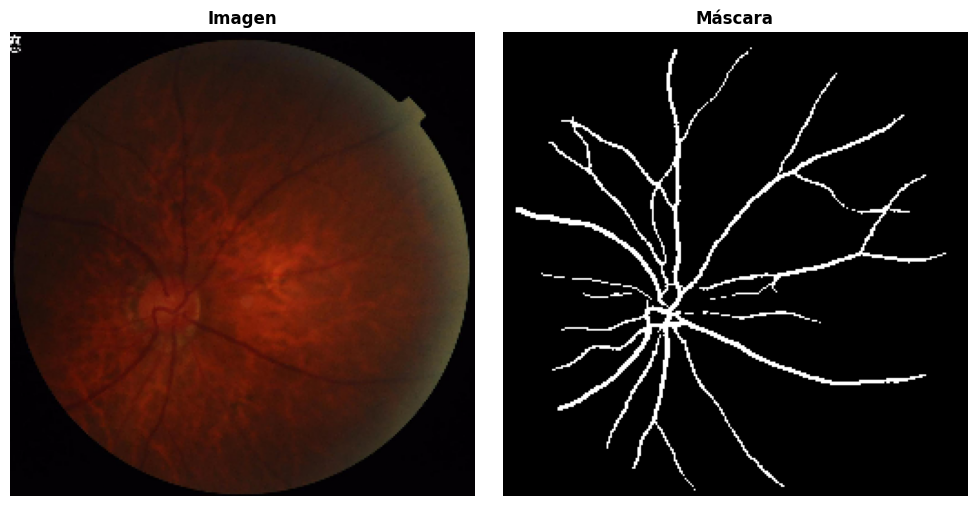

In [ ]:
# Visualizar
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(x_train[0])
ax[0].set_title("Imagen", fontweight='bold')
ax[0].axis('off')
ax[1].imshow(y_train[0].squeeze(), cmap='gray')
ax[1].set_title("Máscara", fontweight='bold')
ax[1].axis('off')
plt.tight_layout()
plt.show()

# **9. Creación del dataset TensorFlow**
Se convierte los arrays de imágenes y máscaras en objetos tf.data.Dataset, optimizando su manejo durante el entrenamiento. Se aplican operaciones de shuffle para mezclar los datos, batching para procesar grupos de muestras de tamaño definido, y prefetch para mejorar la eficiencia del flujo de datos. Además, se aplica la función de aumento de datos (augment_image) a cada lote, lo que contribuye a la generalización del modelo al entrenar con variaciones aleatorias de las imágenes originales.

In [ ]:
def tf_dataset(x,y,batch_size=8):
    dataset = tf.data.Dataset.from_tensor_slices((x,y))
    dataset = dataset.shuffle(buffer_size=8)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = tf_dataset(x_train,y_train,batch_size=8)
test_dataset = tf_dataset(x_test,y_test,batch_size=8)

# **10. Función de entrenamiento y evaluación**

Esta función se encarga de entrenar el modelo sobre el conjunto de datos de entrenamiento y evaluarlo en los datos de prueba. Primero compila el modelo con el optimizador Adam y la pérdida de entropía cruzada binaria, registrando la métrica de accuracy. Durante el entrenamiento, se aplican callbacks como checkpoint y early_stopping para guardar el mejor modelo y detener el entrenamiento si no hay mejora.

Una vez finalizado el entrenamiento, se generan predicciones sobre xtest y se binarizan usando un umbral de 0.3. Luego se calculan tres métricas de desempeño: IoU, accuracy y F1-score. Finalmente, la función libera memoria y limpia la sesión de TensorFlow para evitar sobrecarga.

In [ ]:
def entrenar_y_evaluar(model, train_dataset, test_dataset, xtest, ytest, epochs=5):
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=test_dataset,
        callbacks=[checkpoint, early_stopping],
        verbose=1
    )
    y_pred = model.predict(xtest)
    y_pred_bin = (y_pred > 0.3).astype(np.float32)
    y_test_float = ytest.astype(np.float32)

    iou = iou_coef(y_test_float, y_pred_bin).numpy()
    acc = np.mean(y_test_float.flatten() == y_pred_bin.flatten())
    f1 = f1_score(y_test_float, y_pred_bin).numpy()

    # Limpia la sesión
    del model
    from tensorflow.keras import backend as K
    import gc
    K.clear_session()
    gc.collect()

    return iou, acc, f1


# **11. Definición de métricas externas**

Estas funciones calculan métricas de evaluación para segmentación de imágenes:

* iou_coef: Calcula el Intersection over Union (IoU), midiendo el solapamiento entre la predicción y la máscara real.

* accuracy_coef: Calcula la precisión, evaluando el porcentaje de píxeles correctamente predichos sobre el total.

* f1_score: Calcula el F1 score, combinando precisión y recall para medir el balance entre falsos positivos y falsos negativos.

Todas transforman las entradas a vectores planos para facilitar las operaciones de suma y comparación.

In [ ]:

def iou_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

def accuracy_coef(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    acc = tf.reduce_mean(tf.cast(tf.equal(y_true_f, y_pred_f), tf.float32))
    return acc

def f1_score(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    tp = tf.reduce_sum(y_true_f * y_pred_f)
    fp = tf.reduce_sum((1 - y_true_f) * y_pred_f)
    fn = tf.reduce_sum(y_true_f * (1 - y_pred_f))
    f1 = (2 * tp + smooth) / (2 * tp + fp + fn + smooth)
    return f1


# **12. Visualización de métricas**

Se define una función que grafica IoU, Accuracy y F1 para distintos valores de un parámetro, mostrando su comparación y evolución de manera clara.

In [ ]:
def visualizar_metricas(valores, iou_scores, acc_scores, f1_scores, nombre_parametro, titulo="Métricas vs parámetro"):
    plt.figure(figsize=(8,5))
    plt.plot(valores, iou_scores, marker='o', label='IoU')
    plt.plot(valores, acc_scores, marker='s', label='Accuracy')
    plt.plot(valores, f1_scores, marker='^', label='F1 Score')
    plt.xlabel(nombre_parametro)
    plt.ylabel('Valor métrica')
    plt.title(titulo)
    plt.legend()
    plt.grid()
    plt.show()



# **13. Funciones de experimentos**
Estas funciones son auxiliares para los experimentos:

* Funciones de data augmentation (augment_none, augment_basic, augment_advanced): Definen cómo se modifican las imágenes de entrenamiento para aumentar la variabilidad del dataset. Van desde no aplicar cambios, hasta transformaciones básicas (flip horizontal/vertical) y avanzadas (flip, brillo, contraste y rotación aleatoria).

* Función build_model_pooling: Construye un modelo U-Net donde se puede elegir el tipo de pooling en el encoder (max pooling o average pooling). Esta función se usa específicamente para experimentar con diferentes estrategias de pooling y ver cómo afectan el entrenamiento y desempeño del modelo.

In [ ]:
def augment_none(image, mask):
    return image, mask

def augment_basic(image, mask):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image, mask

def augment_advanced(image, mask):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    return image, mask

def build_model_pooling(input_shape=(256,256,3), pooling_type="max"):
    inputs = Input(shape=input_shape)
    x = inputs
    skips = []
    for i in range(4):
        filters = 64 * (2 ** i)
        x = Conv2D(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        x = Dropout(0.0)(x)
        skips.append(x)
        if pooling_type == "max":
            x = MaxPooling2D((2,2))(x)
        elif pooling_type == "avg":
            x = tf.keras.layers.AveragePooling2D((2,2))(x)
    filters = 64 * (2 ** 4)
    x = Conv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.0)(x)
    for i in reversed(range(4)):
        filters = 64 * (2 ** i)
        x = Conv2DTranspose(filters, 2, strides=2, padding="same")(x)
        x = concatenate([x, skips[i]])
        x = Conv2D(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        x = Dropout(0.0)(x)
    output = Conv2D(1, (1,1), padding="same", activation="sigmoid")(x)
    model = Model(inputs, output)
    return model

## **14. Callbacks**
Aquí se definen los callbacks utilizados durante el entrenamiento del modelo.

checkpoint guarda el modelo con el menor valor de pérdida de validación (val_loss) en el archivo "best_model.keras", asegurando que solo se almacene la mejor versión.

early_stopping detiene automáticamente el entrenamiento si la pérdida de validación no mejora durante 15 épocas consecutivas (patience=15) y restaura los pesos del mejor modelo encontrado hasta ese momento. Esto ayuda a prevenir sobreajuste y acelera el proceso de entrenamiento.

In [ ]:
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_loss',
                             save_best_only=True, mode='min', verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=15, mode='min',
                               verbose=1, restore_best_weights=True)

# **EXPERIMENTOS**
En cada experimento se entrena el modelo modificando un parámetro específico (como el número de capas, la función de activación, el uso de BatchNorm, Dropout, entre otros) y se calculan las métricas **IoU, Accuracy y F1** sobre el conjunto de prueba. Posteriormente, los resultados se visualizan en gráficos que muestran cómo varían estas métricas en función del parámetro evaluado.


# **Experimento 1: Número de capas**
En este experimento se entrena el modelo variando el número de capas del encoder, evaluando configuraciones con 3, 4 y 5 capas para analizar cómo la profundidad de la red afecta el aprendizaje y la capacidad de representación de características.

Entrenando modelo con 3 capas encoder...
Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.8825 - loss: 0.3518
Epoch 1: val_loss did not improve from 0.33429
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 916ms/step - accuracy: 0.8844 - loss: 0.3482 - val_accuracy: 0.9270 - val_loss: 0.5881
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.9303 - loss: 0.2406
Epoch 2: val_loss did not improve from 0.33429
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 307ms/step - accuracy: 0.9302 - loss: 0.2406 - val_accuracy: 0.9269 - val_loss: 0.5374
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.9305 - loss: 0.2319
Epoch 3: val_loss did not improve from 0.33429
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 276ms/step - accuracy: 0.9304 - loss: 0.2322 - val_accuracy: 0.9270 - val_loss: 0.5083
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.9309 - loss: 0.2282
Epoch 4: val_loss did not improve from 0.33429
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 277ms/step - accuracy: 0.9307 - loss: 0.2285 - va

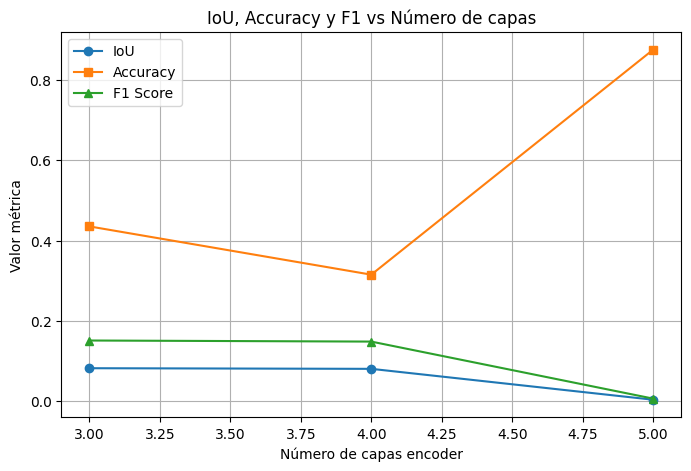

In [ ]:
valores = [3, 4, 5]
iou_scores = []
acc_scores = []
f1_scores = []

for n_layers in valores:
    print(f"Entrenando modelo con {n_layers} capas encoder...")
    model = build_model(num_layers=n_layers)
    iou, acc, f1 = entrenar_y_evaluar(model, train_dataset, test_dataset, x_test, y_test)
    iou_scores.append(iou)
    acc_scores.append(acc)
    f1_scores.append(f1)

visualizar_metricas(valores, iou_scores, acc_scores, f1_scores, "Número de capas encoder", "IoU, Accuracy y F1 vs Número de capas")



# **Experimento 2: Función de activación**
En este experimento se entrena el modelo utilizando distintas funciones de activación, incluyendo ReLU, ELU y Leaky ReLU, para estudiar cómo la elección de la activación influye en el aprendizaje y en la capacidad de la red para capturar patrones en los datos.


Entrenando modelo con activación relu...
Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4973 - loss: 0.8243   
Epoch 1: val_loss improved from inf to 1.45990, saving model to best_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.5126 - loss: 0.8095 - val_accuracy: 0.1597 - val_loss: 1.4599
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.9284 - loss: 0.3455
Epoch 2: val_loss did not improve from 1.45990
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 350ms/step - accuracy: 0.9282 - loss: 0.3445 - val_accuracy: 0.1031 - val_loss: 3.4842
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9288 - loss: 0.2893
Epoch 3: val_loss improved from 1.45990 to 1.31525, saving model to best_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 424ms/step - accuracy: 0.9287 - loss: 0.2890 - val_accuracy: 0.2682 - val_loss: 1.3153
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.9299 - loss: 0.2647
Epoch 4: val_loss improved from 1.31525 to 0.53677, savin

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 557ms/step


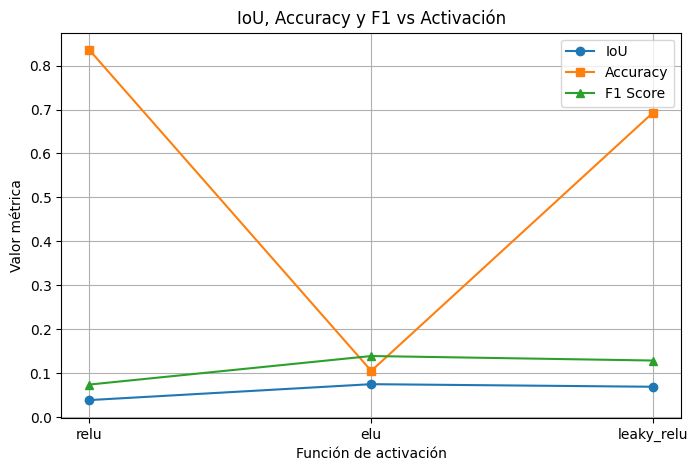

In [ ]:
activaciones = ["relu", "elu", "leaky_relu"]
iou_scores, acc_scores, f1_scores = [], [], []

for act in activaciones:
    print(f"Entrenando modelo con activación {act}...")
    model = build_model(activation=act)
    iou, acc, f1 = entrenar_y_evaluar(model, train_dataset, test_dataset, x_test, y_test)
    iou_scores.append(iou)
    acc_scores.append(acc)
    f1_scores.append(f1)

visualizar_metricas(activaciones, iou_scores, acc_scores, f1_scores, "Función de activación", "IoU, Accuracy y F1 vs Activación")


# **Experimento 3: Uso de Batch Normalization**
En este experimento se entrena el modelo comparando la presencia o ausencia de normalización por lotes (BatchNorm) para evaluar cómo esta técnica afecta el entrenamiento y la estabilidad de la red.


Entrenando modelo con BatchNorm=True...
Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 925ms/step - accuracy: 0.7772 - loss: 0.5093
Epoch 1: val_loss did not improve from 0.36937
13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7830 - loss: 0.5022 - val_accuracy: 0.4152 - val_loss: 0.7615
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.9294 - loss: 0.2641
Epoch 2: val_loss did not improve from 0.36937
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 348ms/step - accuracy: 0.9293 - loss: 0.2637 - val_accuracy: 0.5400 - val_loss: 0.9845
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.9285 - loss: 0.2417
Epoch 3: val_loss did not improve from 0.36937
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 348ms/step - accuracy: 0.9285 - loss: 0.2417 - val_accuracy: 0.1614 - val_loss: 2.1846
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.9301 - loss: 0.2343
Epoch 4: val_loss did not improve from 0.36937
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 355ms/step - accuracy: 0.9300 - loss: 0.2345 - val_ac

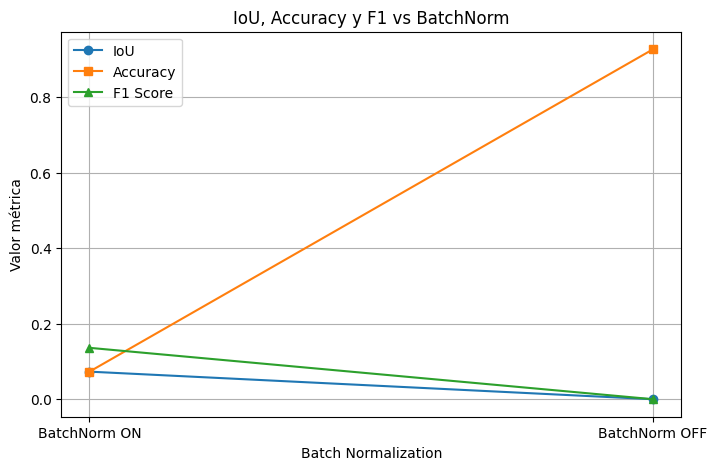

In [ ]:
batchnorms = [True, False]
labels = ["BatchNorm ON", "BatchNorm OFF"]
iou_scores, acc_scores, f1_scores = [], [], []

for bn in batchnorms:
    print(f"Entrenando modelo con BatchNorm={bn}...")
    model = build_model(batchnorm=bn)
    iou, acc, f1 = entrenar_y_evaluar(model, train_dataset, test_dataset, x_test, y_test)
    iou_scores.append(iou)
    acc_scores.append(acc)
    f1_scores.append(f1)

visualizar_metricas(labels, iou_scores, acc_scores, f1_scores, "Batch Normalization", "IoU, Accuracy y F1 vs BatchNorm")


# **Experimento 4: Dropout**
En este experimento se entrena el modelo variando la tasa de Dropout para analizar cómo la regularización mediante abandono de neuronas afecta el aprendizaje y la robustez del modelo.


Entrenando modelo con Dropout=0.0...
Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 780ms/step - accuracy: 0.7835 - loss: 0.4974
Epoch 1: val_loss did not improve from 0.24912
13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7895 - loss: 0.4906 - val_accuracy: 0.2198 - val_loss: 1.0394
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.9297 - loss: 0.2609
Epoch 2: val_loss did not improve from 0.24912
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 338ms/step - accuracy: 0.9295 - loss: 0.2607 - val_accuracy: 0.2541 - val_loss: 2.1887
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.9300 - loss: 0.2439
Epoch 3: val_loss did not improve from 0.24912
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 348ms/step - accuracy: 0.9299 - loss: 0.2440 - val_accuracy: 0.7832 - val_loss: 0.6211
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.9303 - loss: 0.2357
Epoch 4: val_loss did not improve from 0.24912
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 348ms/step - accuracy: 0.9302 - loss: 0.2359 - val_accur

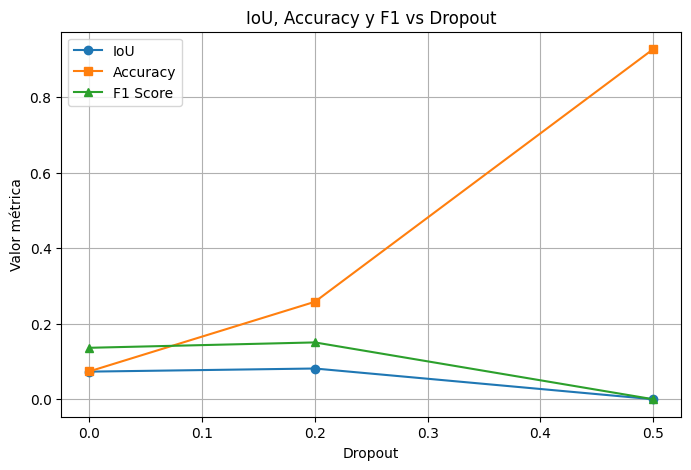

In [ ]:
dropouts = [0.0, 0.2, 0.5]
iou_scores, acc_scores, f1_scores = [], [], []

for drop in dropouts:
    print(f"Entrenando modelo con Dropout={drop}...")
    model = build_model(dropout=drop)
    iou, acc, f1 = entrenar_y_evaluar(model, train_dataset, test_dataset, x_test, y_test)
    iou_scores.append(iou)
    acc_scores.append(acc)
    f1_scores.append(f1)

visualizar_metricas(dropouts, iou_scores, acc_scores, f1_scores, "Dropout", "IoU, Accuracy y F1 vs Dropout")


# **Experimeto 5: Número de filtros base**
En este experimento se entrena el modelo ajustando el número de filtros base en las capas convolucionales, con el fin de evaluar cómo la capacidad de extracción de características influye en el aprendizaje del modelo.


Entrenando modelo con filtros base=16...
Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7561 - loss: 0.5584  
Epoch 1: val_loss improved from inf to 0.64440, saving model to best_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7614 - loss: 0.5543 - val_accuracy: 0.9220 - val_loss: 0.6444
Epoch 2/5
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9271 - loss: 0.3729
Epoch 2: val_loss improved from 0.64440 to 0.60827, saving model to best_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9269 - loss: 0.3708 - val_accuracy: 0.9171 - val_loss: 0.6083
Epoch 3/5
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9286 - loss: 0.3214
Epoch 3: val_loss improved from 0.60827 to 0.55329, saving model to best_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9284 - loss: 0.3209 - val_accuracy: 0.9268 - val_loss: 0.5533
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9303 - loss: 0.2987
Epoch 4: val_loss improve

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 33s 614ms/step


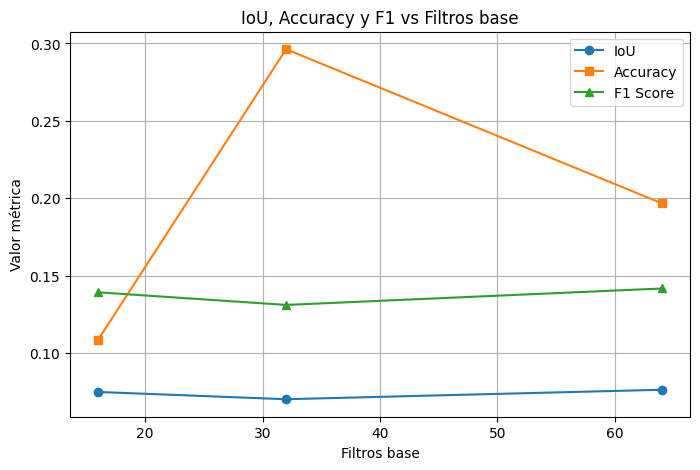

In [ ]:
filtros = [16, 32, 64]
iou_scores, acc_scores, f1_scores = [], [], []

for base_filters in filtros:
    print(f"Entrenando modelo con filtros base={base_filters}...")
    model = build_model(base_filters=base_filters)
    iou, acc, f1 = entrenar_y_evaluar(model, train_dataset, test_dataset, x_test, y_test)
    iou_scores.append(iou)
    acc_scores.append(acc)
    f1_scores.append(f1)

visualizar_metricas(filtros, iou_scores, acc_scores, f1_scores, "Filtros base", "IoU, Accuracy y F1 vs Filtros base")


# **Experimento 6: Skip connections**
En este experimento se compara el entrenamiento del modelo con y sin conexiones de salto (skip connections) para evaluar cómo la reutilización de características intermedias afecta el desempeño de la red.


Entrenando skip connections True...
Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7224 - loss: 0.5873   
Epoch 1: val_loss improved from inf to 1.07080, saving model to best_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.7299 - loss: 0.5792 - val_accuracy: 0.4860 - val_loss: 1.0708
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.9287 - loss: 0.2831
Epoch 2: val_loss improved from 1.07080 to 0.58974, saving model to best_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 429ms/step - accuracy: 0.9286 - loss: 0.2825 - val_accuracy: 0.7193 - val_loss: 0.5897
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.9303 - loss: 0.2492
Epoch 3: val_loss did not improve from 0.58974
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 365ms/step - accuracy: 0.9301 - loss: 0.2492 - val_accuracy: 0.3335 - val_loss: 0.8939
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.9299 - loss: 0.2400
Epoch 4: val_loss improved from 0.58974 to 0.55437, saving mod

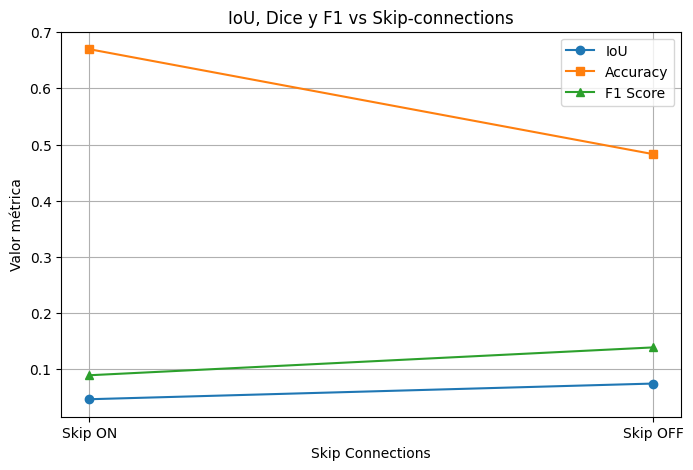

In [ ]:
skips = [True, False]
labels = ["Skip ON", "Skip OFF"]
iou_scores, dice_scores, f1_scores = [], [], []

for use_skip in skips:
    print(f"Entrenando skip connections {use_skip}...")
    model = build_model(use_skip=use_skip)
    iou, dice, f1 = entrenar_y_evaluar(model, train_dataset, test_dataset, x_test, y_test)
    iou_scores.append(iou)
    dice_scores.append(dice)
    f1_scores.append(f1)

visualizar_metricas(labels, iou_scores, dice_scores, f1_scores, "Skip Connections", "IoU, Dice y F1 vs Skip-connections")


# **Experimento 7: Optimizadores**
En este experimento se evalúa el efecto de distintos optimizadores en el entrenamiento del modelo para analizar cómo la elección del algoritmo de optimización influye en la convergencia y el desempeño final de la red.


Entrenando con optimizador adam...
Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 952ms/step - accuracy: 0.7603 - loss: 0.5260
Epoch 1: val_loss did not improve from 0.40616
13/13 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7671 - loss: 0.5183 - val_accuracy: 0.5698 - val_loss: 0.8022
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.9299 - loss: 0.2748
Epoch 2: val_loss did not improve from 0.40616
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 350ms/step - accuracy: 0.9297 - loss: 0.2745 - val_accuracy: 0.3853 - val_loss: 0.9264
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.9315 - loss: 0.2468
Epoch 3: val_loss did not improve from 0.40616
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 359ms/step - accuracy: 0.9313 - loss: 0.2472 - val_accuracy: 0.6834 - val_loss: 0.6793
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9305 - loss: 0.2414
Epoch 4: val_loss did not improve from 0.40616
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 378ms/step - accuracy: 0.9304 - loss: 0.2416 - val_accurac

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 662ms/step
Entrenando con optimizador rmsprop...
Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5103 - loss: 0.7980   
Epoch 1: val_loss did not improve from 0.40616
13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.5245 - loss: 0.7835 - val_accuracy: 0.1103 - val_loss: 1.0688
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.9278 - loss: 0.3011
Epoch 2: val_loss did not improve from 0.40616
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 362ms/step - accuracy: 0.9278 - loss: 0.3006 - val_accuracy: 0.1323 - val_loss: 1.0794
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9295 - loss: 0.2638
Epoch 3: val_loss did not improve from 0.40616
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 373ms/step - accuracy: 0.9294 - loss: 0.2636 - val_accuracy: 0.1256 - val_loss: 1.1708
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.9301 - loss: 0.2495
Epoch 4: val_loss did not improve from 0.40616
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 372ms/step - acc

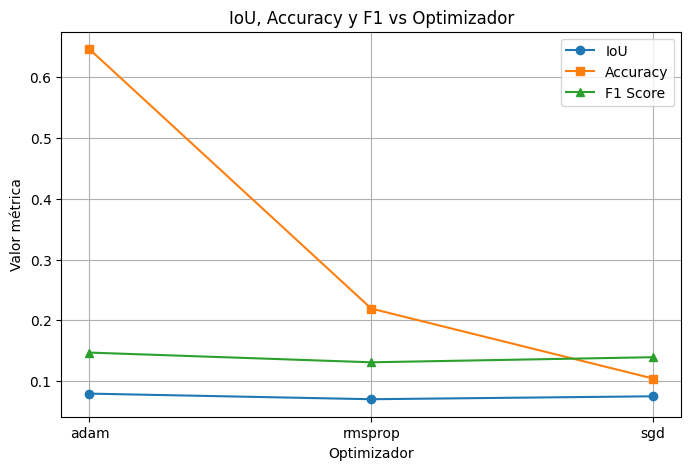

In [ ]:
optimizers = ["adam", "rmsprop", "sgd"]
iou_scores, acc_scores, f1_scores = [], [], []

for opt in optimizers:
    print(f"Entrenando con optimizador {opt}...")
    model = build_model()
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
    iou, acc, f1 = entrenar_y_evaluar(model, train_dataset, test_dataset, x_test, y_test)
    iou_scores.append(iou)
    acc_scores.append(acc)
    f1_scores.append(f1)

visualizar_metricas(optimizers, iou_scores, acc_scores, f1_scores, "Optimizador", "IoU, Accuracy y F1 vs Optimizador")


# **Experimento 8: Learning Rates**
Este experimento compara distintos valores de tasa de aprendizaje para observar cómo afectan la velocidad de entrenamiento y la estabilidad del modelo durante la optimización.


Entrenando con learning rate 0.01...
Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8194 - loss: 0.4694   
Epoch 1: val_loss improved from inf to 0.87060, saving model to best_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.8236 - loss: 0.4631 - val_accuracy: 0.3606 - val_loss: 0.8706
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.9297 - loss: 0.2540
Epoch 2: val_loss did not improve from 0.87060
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 361ms/step - accuracy: 0.9296 - loss: 0.2537 - val_accuracy: 0.2317 - val_loss: 1.2095
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9299 - loss: 0.2378
Epoch 3: val_loss did not improve from 0.87060
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 367ms/step - accuracy: 0.9298 - loss: 0.2379 - val_accuracy: 0.1679 - val_loss: 1.2652
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9313 - loss: 0.2307
Epoch 4: val_loss improved from 0.87060 to 0.66598, saving model to best_model.keras
13/13 ━━━━━━━━

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 559ms/step


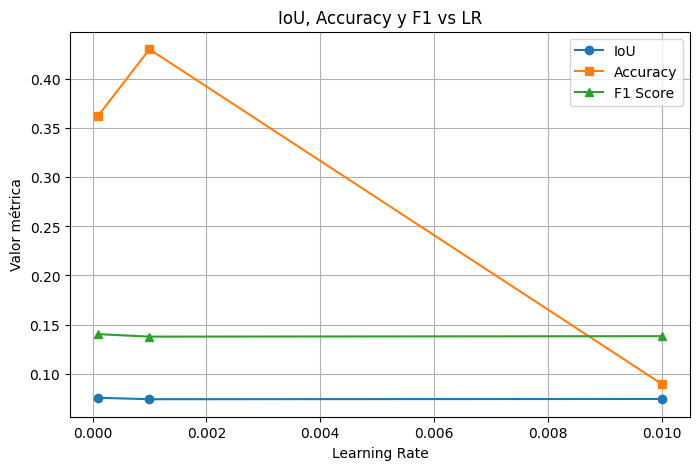

In [ ]:
learning_rates = [0.01, 0.001, 0.0001]
iou_scores, acc_scores, f1_scores = [], [], []

for lr in learning_rates:
    print(f"Entrenando con learning rate {lr}...")
    model = build_model()
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
    iou, acc, f1 = entrenar_y_evaluar(model, train_dataset, test_dataset, x_test, y_test)
    iou_scores.append(iou)
    acc_scores.append(acc)
    f1_scores.append(f1)

visualizar_metricas(learning_rates, iou_scores, acc_scores, f1_scores, "Learning Rate", "IoU, Accuracy y F1 vs LR")


# **Experimento 9: Función de pérdida**
En este experimento se evalúa cómo la elección de la función de pérdida influye en el entrenamiento y comportamiento del modelo, probando distintas alternativas para observar su impacto en la convergencia y resultados finales.


Entrenando con loss binary_crossentropy...
Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 832ms/step - accuracy: 0.5264 - loss: 0.7945
Epoch 1: val_loss did not improve from 0.45622
13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5417 - loss: 0.7795 - val_accuracy: 0.1206 - val_loss: 3.9206
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.9284 - loss: 0.3241
Epoch 2: val_loss did not improve from 0.45622
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 353ms/step - accuracy: 0.9282 - loss: 0.3235 - val_accuracy: 0.0996 - val_loss: 4.5736
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.9295 - loss: 0.2789
Epoch 3: val_loss did not improve from 0.45622
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 369ms/step - accuracy: 0.9293 - loss: 0.2788 - val_accuracy: 0.2757 - val_loss: 1.3912
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.9298 - loss: 0.2623
Epoch 4: val_loss did not improve from 0.45622
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 366ms/step - accuracy: 0.9297 - loss: 0.2623 - val

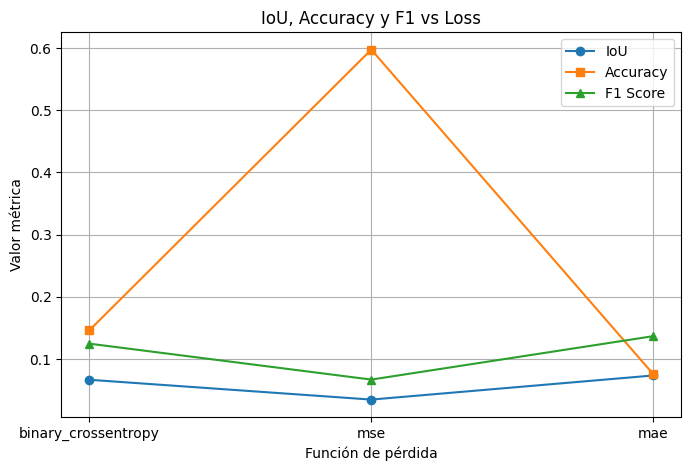

In [ ]:
losses = ["binary_crossentropy", "mse", "mae"]
iou_scores, acc_scores, f1_scores = [], [], []

for loss_fn in losses:
    print(f"Entrenando con loss {loss_fn}...")
    model = build_model()
    model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])
    iou, acc, f1 = entrenar_y_evaluar(model, train_dataset, test_dataset, x_test, y_test)
    iou_scores.append(iou)
    acc_scores.append(acc)
    f1_scores.append(f1)

visualizar_metricas(losses, iou_scores, acc_scores, f1_scores, "Función de pérdida", "IoU, Accuracy y F1 vs Loss")


# **Experimento 10: Número de imágenes**
En este experimento se analiza el efecto del tamaño del conjunto de entrenamiento sobre el modelo, variando la cantidad de imágenes utilizadas para observar cómo influye en el aprendizaje y comportamiento durante el entrenamiento.


Entrenando con 50 imágenes...
Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 786ms/step - accuracy: 0.7180 - loss: 0.5751
Epoch 1: val_loss did not improve from 0.45622
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7260 - loss: 0.5662 - val_accuracy: 0.3603 - val_loss: 1.2361
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.9315 - loss: 0.2661
Epoch 2: val_loss did not improve from 0.45622
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 355ms/step - accuracy: 0.9312 - loss: 0.2660 - val_accuracy: 0.3140 - val_loss: 1.8571
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.9305 - loss: 0.2460
Epoch 3: val_loss did not improve from 0.45622
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 363ms/step - accuracy: 0.9304 - loss: 0.2462 - val_accuracy: 0.6668 - val_loss: 0.6442
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9298 - loss: 0.2390
Epoch 4: val_loss did not improve from 0.45622
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 364ms/step - accuracy: 0.9297 - loss: 0.2391 - val_accuracy: 0.

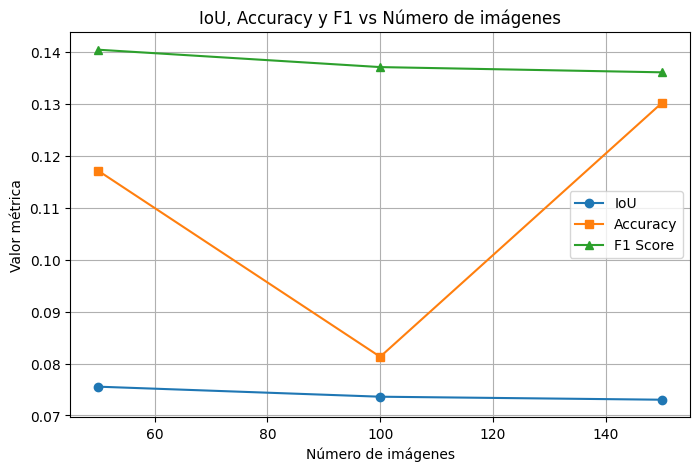

In [ ]:
num_imagenes_lista = [50, 100, 150]
iou_scores, acc_scores, f1_scores = [], [], []

for n_imgs in num_imagenes_lista:
    print(f"Entrenando con {n_imgs} imágenes...")
    model = build_model()
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    iou, acc, f1 = entrenar_y_evaluar(model, train_dataset, test_dataset, x_test, y_test)
    iou_scores.append(iou)
    acc_scores.append(acc)
    f1_scores.append(f1)

visualizar_metricas(num_imagenes_lista, iou_scores, acc_scores, f1_scores, "Número de imágenes", "IoU, Accuracy y F1 vs Número de imágenes")


# **Experimento 11: Data Augmentation**
En este experimento se evalúa cómo diferentes estrategias de aumento de datos afectan el entrenamiento del modelo, comparando conjuntos sin augmentación, con augmentación básica y con augmentación avanzada para observar su impacto en el aprendizaje.


Entrenando con augmentation: none...
Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - accuracy: 0.7803 - loss: 0.5277
Epoch 1: val_loss did not improve from 0.45622
13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7864 - loss: 0.5197 - val_accuracy: 0.1508 - val_loss: 1.1536
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.9308 - loss: 0.2481
Epoch 2: val_loss did not improve from 0.45622
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 357ms/step - accuracy: 0.9307 - loss: 0.2477 - val_accuracy: 0.2107 - val_loss: 1.7247
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.9322 - loss: 0.2179
Epoch 3: val_loss did not improve from 0.45622
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 358ms/step - accuracy: 0.9321 - loss: 0.2178 - val_accuracy: 0.1086 - val_loss: 2.6097
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9357 - loss: 0.1936
Epoch 4: val_loss did not improve from 0.45622
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 367ms/step - accuracy: 0.9357 - loss: 0.1935 - val_accur

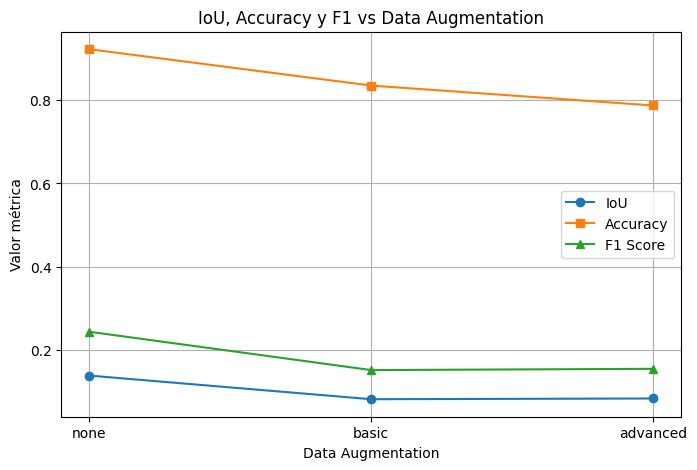

In [ ]:
augmentation_types = ["none", "basic", "advanced"]
iou_scores, acc_scores, f1_scores = [], [], []

for aug_type in augmentation_types:
    print(f"Entrenando con augmentation: {aug_type}...")
    if aug_type == "none":
        train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(8).batch(8).map(augment_none, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
    elif aug_type == "basic":
        train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(8).batch(8).map(augment_basic, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
    elif aug_type == "advanced":
        train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(8).batch(8).map(augment_advanced, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

    test_ds = tf_dataset(x_test, y_test, batch_size=8)
    model = build_model()
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    iou, acc, f1 = entrenar_y_evaluar(model, train_ds, test_ds, x_test, y_test)
    iou_scores.append(iou)
    acc_scores.append(acc)
    f1_scores.append(f1)

visualizar_metricas(augmentation_types, iou_scores, acc_scores, f1_scores, "Data Augmentation", "IoU, Accuracy y F1 vs Data Augmentation")


# **Experimento 12: Tamaño de Kernel**
En este experimento se analiza el efecto del tamaño del kernel en las capas convolucionales del modelo, probando distintas dimensiones (3x3, 5x5 y 7x7) para evaluar cómo influyen en el aprendizaje y la extracción de características.


Entrenando con kernel size 3x3...
Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5632 - loss: 0.7205   
Epoch 1: val_loss improved from inf to 2.37570, saving model to best_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.5769 - loss: 0.7077 - val_accuracy: 0.1739 - val_loss: 2.3757
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.9279 - loss: 0.3036
Epoch 2: val_loss did not improve from 2.37570
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 365ms/step - accuracy: 0.9278 - loss: 0.3030 - val_accuracy: 0.1229 - val_loss: 3.5580
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.9293 - loss: 0.2697
Epoch 3: val_loss improved from 2.37570 to 0.87600, saving model to best_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 611ms/step - accuracy: 0.9292 - loss: 0.2695 - val_accuracy: 0.5546 - val_loss: 0.8760
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.9300 - loss: 0.2520
Epoch 4: val_loss improved from 0.87600 to 0.75620, saving model

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 135s 784ms/step


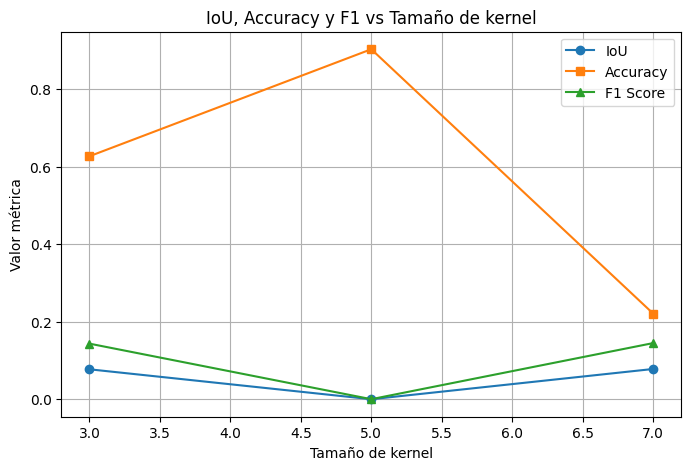

In [ ]:
kernel_sizes = [3, 5, 7]
iou_scores, acc_scores, f1_scores = [], [], []

for k_size in kernel_sizes:
    print(f"Entrenando con kernel size {k_size}x{k_size}...")

    def build_model_kernel(input_shape=(256, 256, 3), kernel_size=k_size):
        inputs = Input(shape=input_shape)
        x = inputs
        skips = []
        for i in range(4):
            filters = 64 * (2 ** i)
            x = Conv2D(filters, kernel_size, padding="same")(x)
            x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Dropout(0.0)(x)
            skips.append(x)
            x = MaxPooling2D((2,2))(x)
        filters = 64 * (2 ** 4)
        x = Conv2D(filters, kernel_size, padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        x = Dropout(0.0)(x)
        for i in reversed(range(4)):
            filters = 64 * (2 ** i)
            x = Conv2DTranspose(filters, 2, strides=2, padding="same")(x)
            x = concatenate([x, skips[i]])
            x = Conv2D(filters, kernel_size, padding="same")(x)
            x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Dropout(0.0)(x)
        output = Conv2D(1, (1,1), padding="same", activation="sigmoid")(x)
        return Model(inputs, output)

    model = build_model_kernel()
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    iou, acc, f1 = entrenar_y_evaluar(model, train_dataset, test_dataset, x_test, y_test)
    iou_scores.append(iou)
    acc_scores.append(acc)
    f1_scores.append(f1)

visualizar_metricas(kernel_sizes, iou_scores, acc_scores, f1_scores, "Tamaño de kernel", "IoU, Accuracy y F1 vs Tamaño de kernel")


# **Experimento 13: Pooling**
En este experimento se compara el impacto de diferentes estrategias de *pooling* (max pooling vs average pooling) dentro del modelo, para observar cómo afectan la reducción de dimensionalidad y la extracción de características durante el entrenamiento.


Entrenando con pooling: max...
Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 858ms/step - accuracy: 0.7894 - loss: 0.5081
Epoch 1: val_loss improved from 8.76919 to 1.03819, saving model to best_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7949 - loss: 0.5009 - val_accuracy: 0.1684 - val_loss: 1.0382
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.9305 - loss: 0.2581
Epoch 2: val_loss did not improve from 1.03819
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 356ms/step - accuracy: 0.9304 - loss: 0.2579 - val_accuracy: 0.1661 - val_loss: 1.2123
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.9312 - loss: 0.2385
Epoch 3: val_loss did not improve from 1.03819
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 369ms/step - accuracy: 0.9310 - loss: 0.2387 - val_accuracy: 0.1291 - val_loss: 1.6905
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.9309 - loss: 0.2321
Epoch 4: val_loss improved from 1.03819 to 0.96350, saving model to best_model.keras
13/13 ━━━━━━━━━━

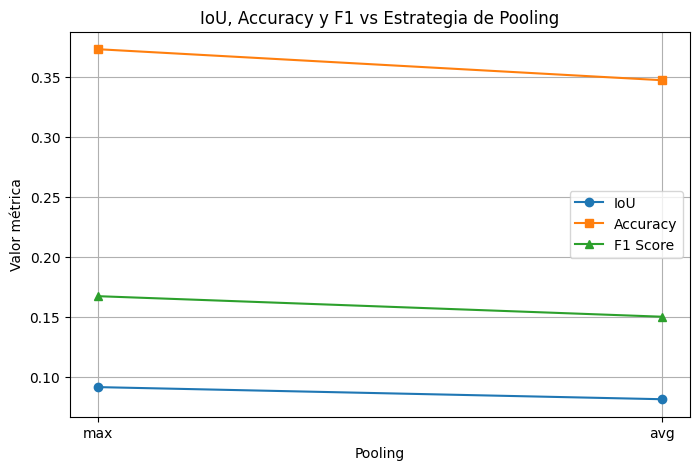

In [ ]:
poolings = ["max", "avg"]
iou_scores, acc_scores, f1_scores = [], [], []

for pool_type in poolings:
    print(f"Entrenando con pooling: {pool_type}...")
    model = build_model_pooling(pooling_type=pool_type)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    iou, acc, f1 = entrenar_y_evaluar(model, train_dataset, test_dataset, x_test, y_test)
    iou_scores.append(iou)
    acc_scores.append(acc)
    f1_scores.append(f1)

visualizar_metricas(poolings, iou_scores, acc_scores, f1_scores, "Pooling", "IoU, Accuracy y F1 vs Estrategia de Pooling")


# **Experimento 14: Tamaño de imagen**
En este experimento se evalúa cómo el tamaño de las imágenes de entrada afecta el entrenamiento del modelo. Para cada tamaño (256x256, 128x128 y 64x64), se redimensionan las imágenes, se construye y entrena el modelo, y se calculan las métricas de rendimiento sobre el conjunto de prueba.


256x256

In [ ]:
img_size = (256, 256)
print(f"Entrenando con imagen de tamaño {img_size}...")

x_train_resize, y_train_resize = load_data(f"{download_path}/train", img_size=img_size)
x_test_resize, y_test_resize = load_data(f"{download_path}/test", img_size=img_size)
train_dataset_resize = tf_dataset(x_train_resize, y_train_resize, batch_size=8)
test_dataset_resize = tf_dataset(x_test_resize, y_test_resize, batch_size=8)

model = build_model(input_shape=(img_size[0], img_size[1], 3))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
iou, acc, f1 = entrenar_y_evaluar(model, train_dataset_resize, test_dataset_resize, x_test_resize, y_test_resize)

print("Resultados para tamaño 256x256:")
print("IoU:", iou)
print("Accuracy:", acc)
print("F1:", f1)


Entrenando con imagen de tamaño (256, 256)...
Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 877ms/step - accuracy: 0.8157 - loss: 0.4910
Epoch 1: val_loss improved from 0.55383 to 0.43964, saving model to best_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8204 - loss: 0.4836 - val_accuracy: 0.9156 - val_loss: 0.4396
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.9289 - loss: 0.2527
Epoch 2: val_loss did not improve from 0.43964
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 365ms/step - accuracy: 0.9288 - loss: 0.2525 - val_accuracy: 0.8058 - val_loss: 0.5665
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.9310 - loss: 0.2366
Epoch 3: val_loss did not improve from 0.43964
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 355ms/step - accuracy: 0.9308 - loss: 0.2369 - val_accuracy: 0.9162 - val_loss: 0.5042
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.9310 - loss: 0.2304
Epoch 4: val_loss did not improve from 0.43964
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 355ms/ste

128x128

In [ ]:
img_size = (128, 128)
print(f"Entrenando con imagen de tamaño {img_size}...")

x_train_resize, y_train_resize = load_data(f"{download_path}/train", img_size=img_size)
x_test_resize, y_test_resize = load_data(f"{download_path}/test", img_size=img_size)
train_dataset_resize = tf_dataset(x_train_resize, y_train_resize, batch_size=8)
test_dataset_resize = tf_dataset(x_test_resize, y_test_resize, batch_size=8)

model = build_model(input_shape=(img_size[0], img_size[1], 3))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
iou, dice, f1 = entrenar_y_evaluar(model, train_dataset_resize, test_dataset_resize, x_test_resize, y_test_resize)

print("Resultados para tamaño 128x128:")
print("IoU:", iou)
print("Accuracy:", acc)
print("F1:", f1)


Entrenando con imagen de tamaño (128, 128)...
Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6014 - loss: 0.7714  
Epoch 1: val_loss did not improve from 0.43073
13/13 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.6132 - loss: 0.7581 - val_accuracy: 0.2932 - val_loss: 1.0944
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9261 - loss: 0.3084
Epoch 2: val_loss did not improve from 0.43073
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.9260 - loss: 0.3076 - val_accuracy: 0.1053 - val_loss: 7.4980
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9281 - loss: 0.2649
Epoch 3: val_loss did not improve from 0.43073
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.9280 - loss: 0.2649 - val_accuracy: 0.2852 - val_loss: 0.9960
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9280 - loss: 0.2525
Epoch 4: val_loss did not improve from 0.43073
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.9280 - loss: 0.2524 - val_

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 389ms/step
Resultados para tamaño 128x128:
IoU: 0.0580945
Accuracy: 0.46464813232421875
F1: 0.10980967


64x64

In [ ]:
img_size = (64, 64)
print(f"Entrenando con imagen de tamaño {img_size}...")

x_train_resize, y_train_resize = load_data(f"{download_path}/train", img_size=img_size)
x_test_resize, y_test_resize = load_data(f"{download_path}/test", img_size=img_size)
train_dataset_resize = tf_dataset(x_train_resize, y_train_resize, batch_size=8)
test_dataset_resize = tf_dataset(x_test_resize, y_test_resize, batch_size=8)

model = build_model(input_shape=(img_size[0], img_size[1], 3))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
iou, dice, f1 = entrenar_y_evaluar(model, train_dataset_resize, test_dataset_resize, x_test_resize, y_test_resize)

print("Resultados para tamaño 64x64:")
print("IoU:", iou)
print("Accuracy:", acc)
print("F1:", f1)


Entrenando con imagen de tamaño (64, 64)...
Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 937ms/step - accuracy: 0.5924 - loss: 0.7161
Epoch 1: val_loss did not improve from 0.41554
13/13 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.6036 - loss: 0.7056 - val_accuracy: 0.5123 - val_loss: 1.7776
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9267 - loss: 0.3174
Epoch 2: val_loss did not improve from 0.41554
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9267 - loss: 0.3162 - val_accuracy: 0.1583 - val_loss: 1.4856
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9297 - loss: 0.2634
Epoch 3: val_loss did not improve from 0.41554
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9296 - loss: 0.2633 - val_accuracy: 0.4084 - val_loss: 0.8177
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9281 - loss: 0.2515
Epoch 4: val_loss did not improve from 0.41554
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9280 - loss: 0.2515 - val_accu

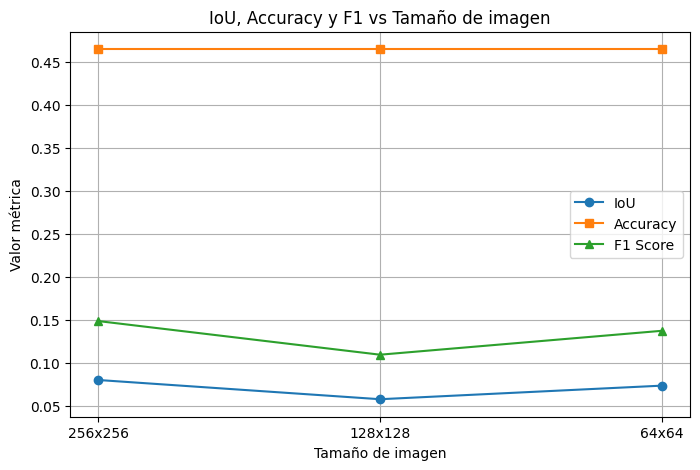

In [ ]:
image_sizes = ["256x256", "128x128", "64x64"]
iou_scores = [0.08043032, 0.0580945, 0.073868036]
acc_scores = [0.46464813232421875, 0.46464813232421875, 0.46464813232421875]
f1_scores = [0.14888573, 0.10980967, 0.13757376]

plt.figure(figsize=(8,5))
plt.plot(image_sizes, iou_scores, marker='o', label='IoU')
plt.plot(image_sizes, acc_scores, marker='s', label='Accuracy')
plt.plot(image_sizes, f1_scores, marker='^', label='F1 Score')
plt.xlabel('Tamaño de imagen')
plt.ylabel('Valor métrica')
plt.title('IoU, Accuracy y F1 vs Tamaño de imagen')
plt.legend()
plt.grid()
plt.show()


# **CONCLUSIÓN**
En este trabajo se ha evaluado de forma sistemática el impacto de 14 parámetros de la arquitectura U‑Net y del proceso de entrenamiento en la tarea de segmentación de vasos sanguíneos en imágenes de fondo de ojo. Los resultados muestran que el rendimiento del modelo no depende de un único hiperparámetro, sino de la combinación adecuada de profundidad de la red, regularización, configuración del optimizador, preprocesado de las imágenes y tamaño efectivo del conjunto de datos.​

**Diferencia entre el accuracy de las épocas y el accuracy calculado.**
Durante el entrenamiento, el modelo se compila con la métrica integrada de accuracy, por lo que en cada época se muestra un valor de accuracy y val_accuracy calculado internamente por la librería a partir de las predicciones continuas del modelo y las máscaras reales. Esa métrica usa su propio criterio de umbralización/ comparación sobre probabilidades entre 0 y 1, mientras que en la evaluación final se sigue otro procedimiento: primero se obtienen las predicciones sobre el conjunto de test, se binarizan con un umbral fijo de 0.3 y, a partir de esas máscaras binarias, se calcula manualmente el accuracy como la proporción de píxeles exactamente iguales entre predicción y ground truth. Como ambos cálculos no utilizan el mismo criterio de decisión sobre las probabilidades de salida, los valores de accuracy reportados durante las épocas y el accuracy final calculado con la fórmula pueden diferir de manera apreciable, aunque estén midiendo la misma idea general de “porcentaje de aciertos”.

**Métricas de la segmentación.**
Las métricas específicas de segmentación, como IoU y F1, presentan valores bajos en comparación con el accuracy global porque son mucho más estrictas y están centradas en la clase minoritaria (los vasos). En las imágenes retinianas la mayor parte de los píxeles pertenecen al fondo, mientras que los vasos ocupan un porcentaje reducido del total. El accuracy se ve favorecido por este desbalance, ya que acertar la gran cantidad de píxeles de fondo produce valores altos incluso si la segmentación de vasos no es muy precisa. En cambio, IoU y F1 solo consideran verdaderos positivos, falsos positivos y falsos negativos de la clase “vaso”, penalizando fuertemente los errores sobre estructuras finas y poco frecuentes. Además, el número reducido de épocas de entrenamiento y el tamaño limitado del conjunto de datos hacen que el modelo no llegue a explotar todo su potencial, lo que se traduce en IoU y F1 modestos a pesar de un accuracy global elevado.​

**Hallazgos principales y configuración recomendada.**
A partir de los experimentos realizados, se ha observado que configuraciones con 3‑4 capas en el encoder, uso moderado de Dropout, funciones de activación tipo ReLU/Leaky ReLU y un optimizador como Adam con una tasa de aprendizaje pequeña proporcionan el mejor compromiso entre capacidad de representación y generalización. Otros parámetros, como el número de filtros base o el tamaño de imagen dentro de los rangos probados, tienen un impacto menor en el rendimiento global. En conjunto, los resultados refuerzan la idea de que, en segmentación médica, es imprescindible analizar métricas como IoU y F1, además del accuracy, y que una selección cuidadosa de hiperparámetros y un entrenamiento más prolongado sobre más datos son claves para mejorar la calidad de las máscaras de vasos obtenidas.